### Informative score and similarity analysis

In [22]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from scipy.stats import spearmanr as scor
from statsmodels.stats.multitest import multipletests

In [11]:
def plot_correaltions_all(dname1,name1,abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard'):
    sns.set_palette('GnBu',5)
    dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
    dnames.sort(reverse=True)
    activities=pd.Series()
    similiarities=pd.Series()
    sizes=pd.Series()
    dset_names=[]
    for dname in dnames:
        activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                         sep=',',header=0,index_col=0).abs().max(1)
        if dname1<dname:
            fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
        else:
            fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
        similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
        size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                         header=0,index_col=0)
        size=size['Set'].value_counts()
        if dname1<dname:
            similarity=similarity.max(0)
        else:
            similarity=similarity.max(1)
        sets=list(set(activity.index)&set(similarity.index)) 
        activities=pd.concat([activities,activity[sets]])   
        similiarities=pd.concat([similiarities,similarity[sets]])
        sizes=pd.concat([sizes,size[sets]])
        if 'dorothea' not in dname:
            dset_names+=[dname]*len(sets)
        elif dname == 'BEST_dorothea_AB':
            dset_names += ['High confidence\nDoRothEA']*len(sets)
        else:
            dset_names += ['Low confidence\nDoRothEA']*len(sets)
    plt.figure(figsize=(5,4),dpi=300)
    sns.scatterplot(similiarities,activities,hue=dset_names)
    if sim_type=='jaccard':
        sim_label='Jaccard index'
    else:
        sim_label='Overlap coefficient'
    plt.xlabel('Similarity to '+name1+'\n('+sim_label+')',size=15)
    plt.ylabel('Informative score',size=15)
    plt.legend(fontsize=7.5)
    print(scor(activities,similiarities))

SpearmanrResult(correlation=0.23584305188949806, pvalue=3.7189093459986374e-65)


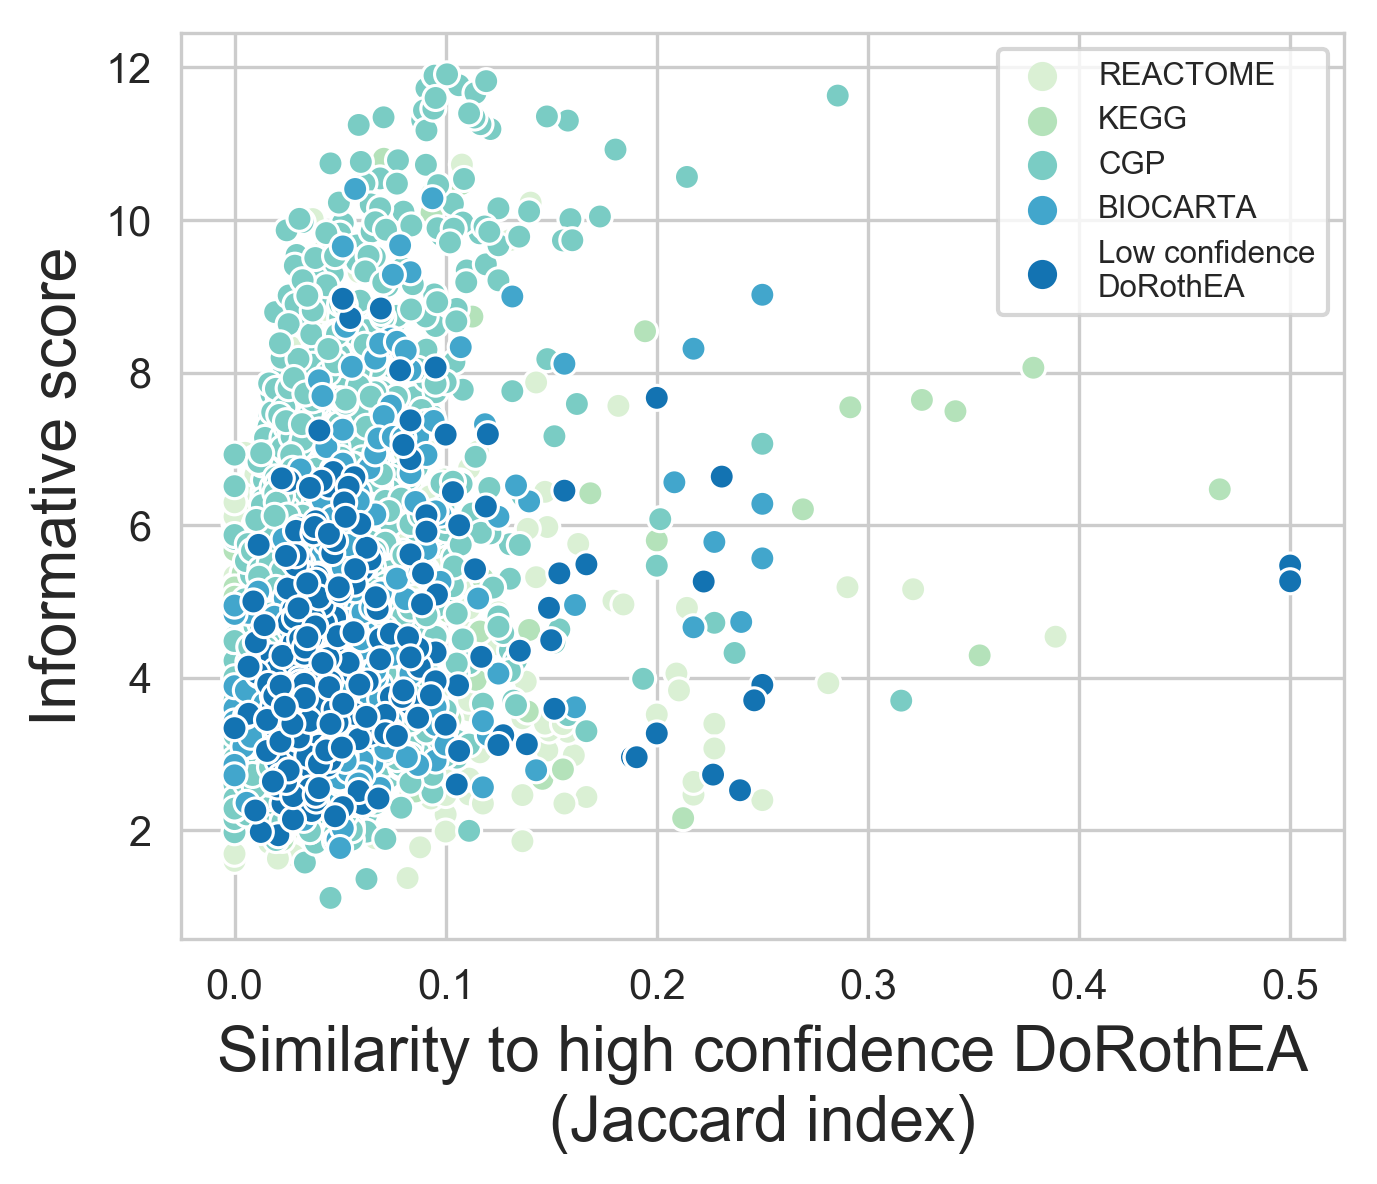

In [12]:
plot_correaltions_all('BEST_dorothea_AB','high confidence DoRothEA','_abs','_filtered','progeny','jaccard')
plt.savefig('../figures/raw/Fig4A.pdf')

SpearmanrResult(correlation=0.030150997717194566, pvalue=0.03481435101401067)


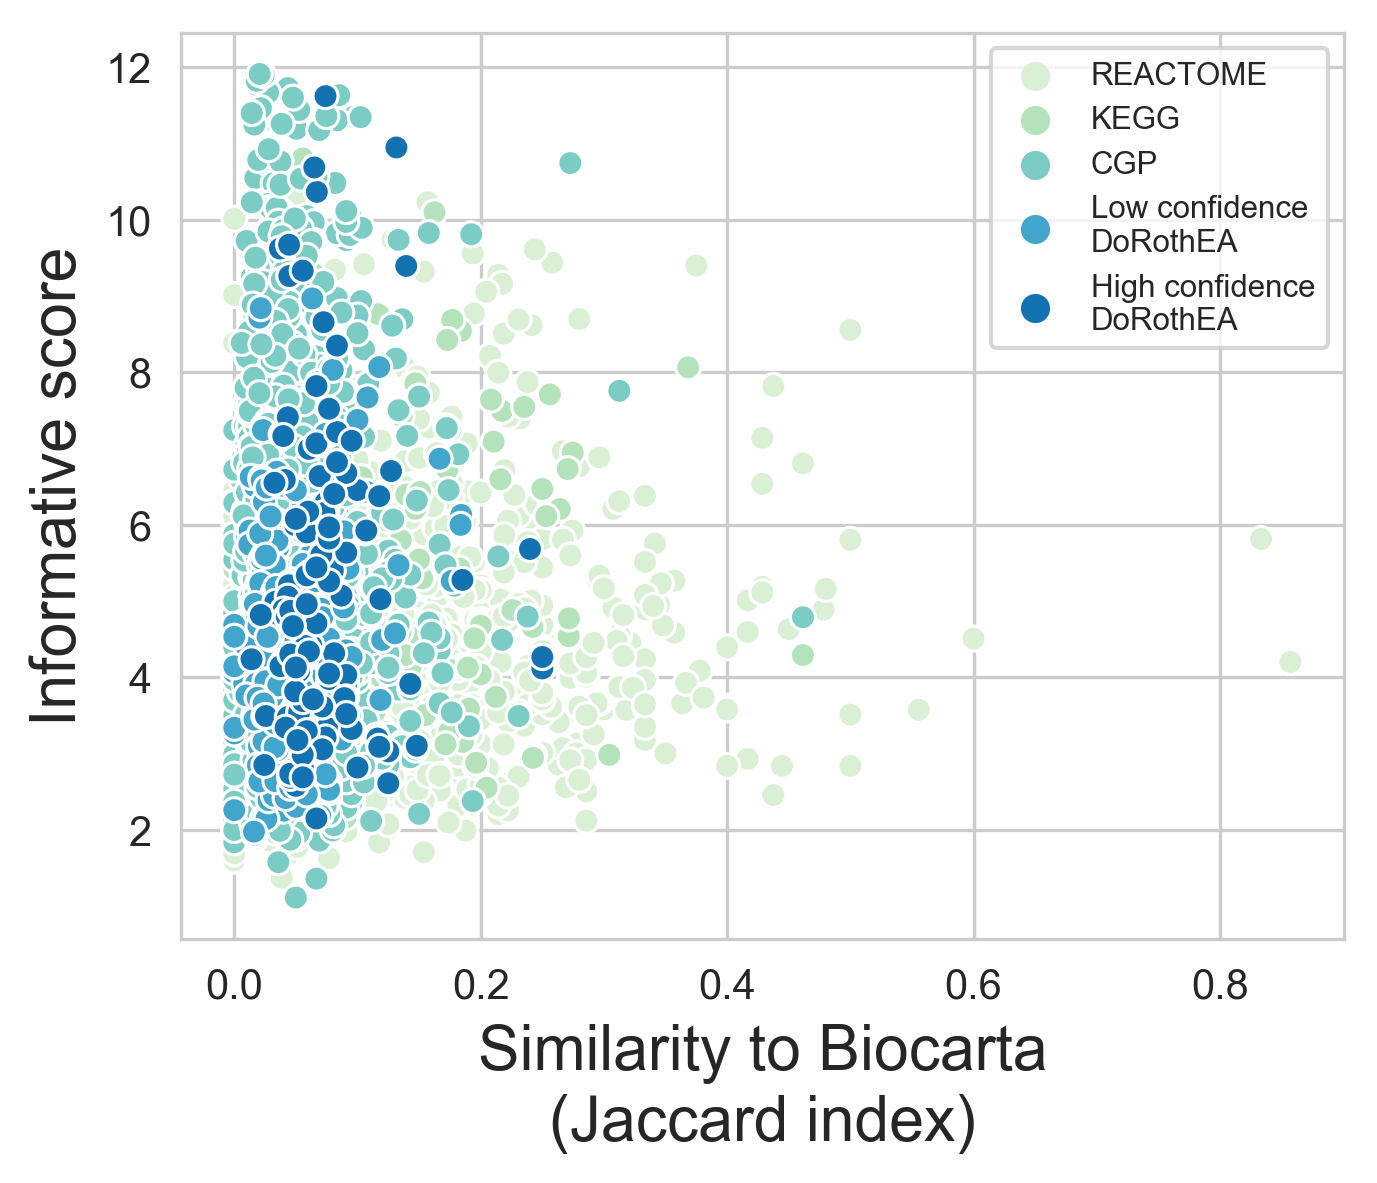

In [13]:
plot_correaltions_all('BIOCARTA','Biocarta','_abs','_filtered','progeny','jaccard')
plt.savefig('../figures/raw/Fig4B.pdf')

In [30]:
def get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard'):
    dsets={'BEST_dorothea_AB':['High confidence\nDoRothEA'],
           'BEST_dorothea_CD':['Low confidence\nDoRothEA'],
           'KEGG':['KEGG'],
           'BIOCARTA':['BIOCARTA'],
           'REACTOME':['REACTOME'],
           'CGP':['CGP']}

    for dname1 in dsets:
        dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
        dnames.sort(reverse=True)
        activities=pd.Series()
        similiarities=pd.Series()
        sizes=pd.Series()
        dset_names=[]
        for dname in dnames:
            activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                             sep=',',header=0,index_col=0).abs().max(1)
            if dname1<dname:
                fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
            else:
                fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
            similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
            size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                             header=0,index_col=0)
            size=size['Set'].value_counts()
            if dname1<dname:
                similarity=similarity.max(0)
            else:
                similarity=similarity.max(1)
            sets=list(set(activity.index)&set(similarity.index)) 
            activities=pd.concat([activities,activity[sets]])   
            similiarities=pd.concat([similiarities,similarity[sets]])
            sizes=pd.concat([sizes,size[sets]])
            dset_names+=[dname]*len(sets)
        dsets[dname1].append(scor(activities,similiarities))
    sns.set_palette('GnBu',2)
    temp = dsets.copy()
    dsets=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
    plt.figure(figsize=(5,4),dpi=300)
    plt.stem(np.arange(0.5,6.5,1), [temp[x][1][0] for x in dsets])
    plt.xticks(np.arange(0.5,6.5,1),[temp[x][0] for x in dsets],
          rotation=45)
    plt.ylim(-0.1,0.3)
    plt.xlabel('Similarity to gene set database')
    plt.ylabel('Spearman correlation between\nsimilarity and infromative score')
    plt.tight_layout()
    ds = [d for d in temp]
    ps = [temp[p][1][1] for p in temp]
    ps = pd.Series(multipletests(ps, method='bonferroni')[1], index=ds)
    rs = pd.Series([temp[x][1][0] for x in temp], index=ds)
    return ps, rs

BIOCARTA            2.088861e-01
BEST_dorothea_CD    3.562320e-06
CGP                 1.651477e-29
REACTOME            1.064747e-01
KEGG                5.782896e-08
BEST_dorothea_AB    2.231346e-64
dtype: float64
BIOCARTA            0.030151
BEST_dorothea_CD    0.070971
CGP                 0.236948
REACTOME            0.038710
KEGG                0.080955
BEST_dorothea_AB    0.235843
dtype: float64


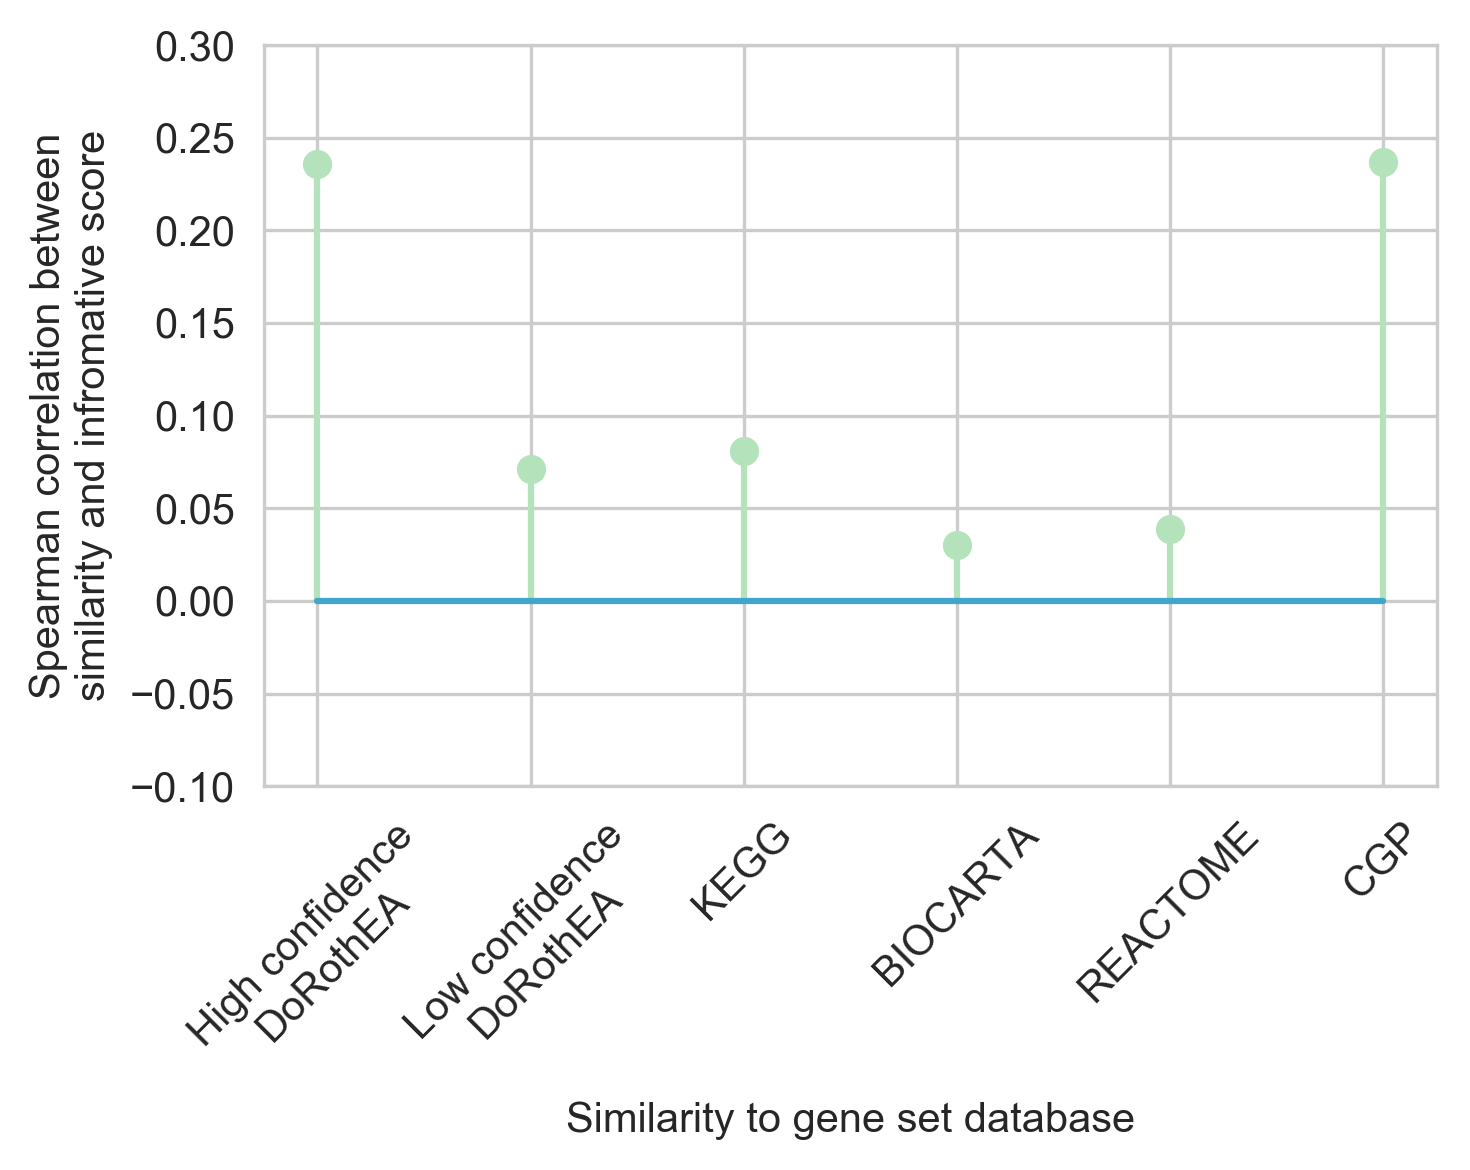

In [33]:
ps, rs = get_correlations_all_datasets()
plt.savefig('../figures/raw/Fig4C.pdf')
print(ps)
print(rs)

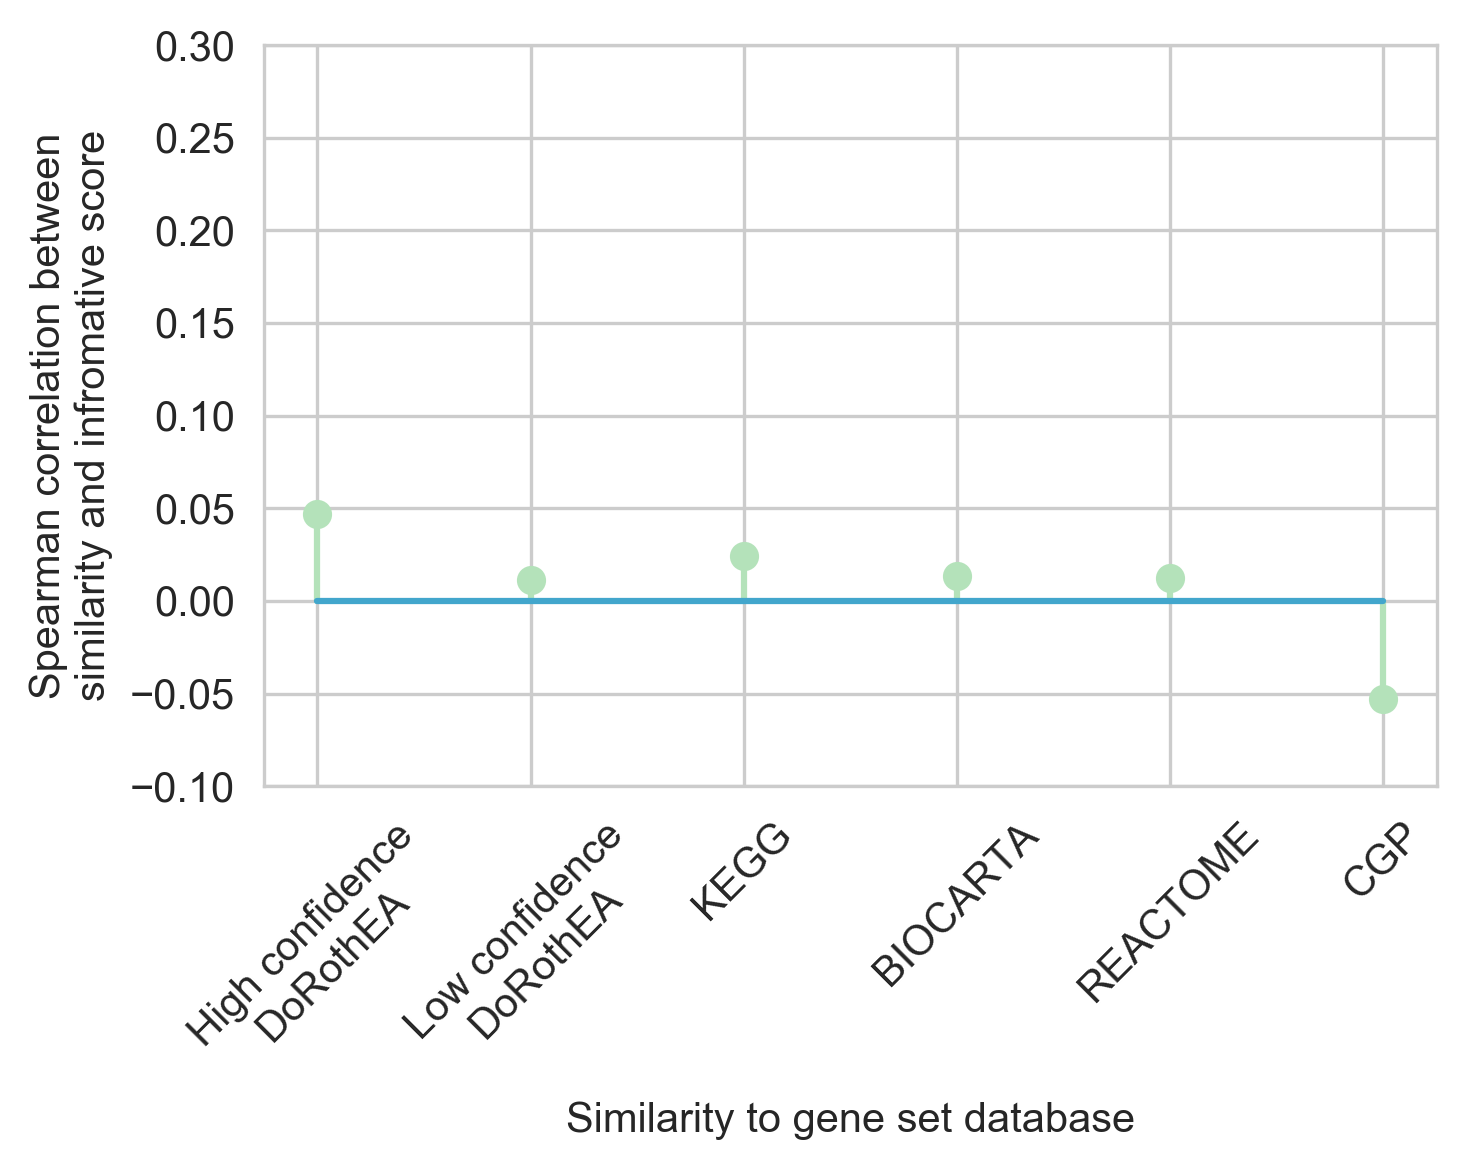

In [34]:
get_correlations_all_datasets(rnd_fil='_random_uniform_0')
plt.savefig('../figures/raw/Fig4D.pdf')

BIOCARTA            2.088861e-01
BEST_dorothea_CD    3.562320e-06
CGP                 1.651477e-29
REACTOME            1.064747e-01
KEGG                5.782896e-08
BEST_dorothea_AB    2.231346e-64
dtype: float64
BIOCARTA            0.030151
BEST_dorothea_CD    0.070971
CGP                 0.236948
REACTOME            0.038710
KEGG                0.080955
BEST_dorothea_AB    0.235843
dtype: float64


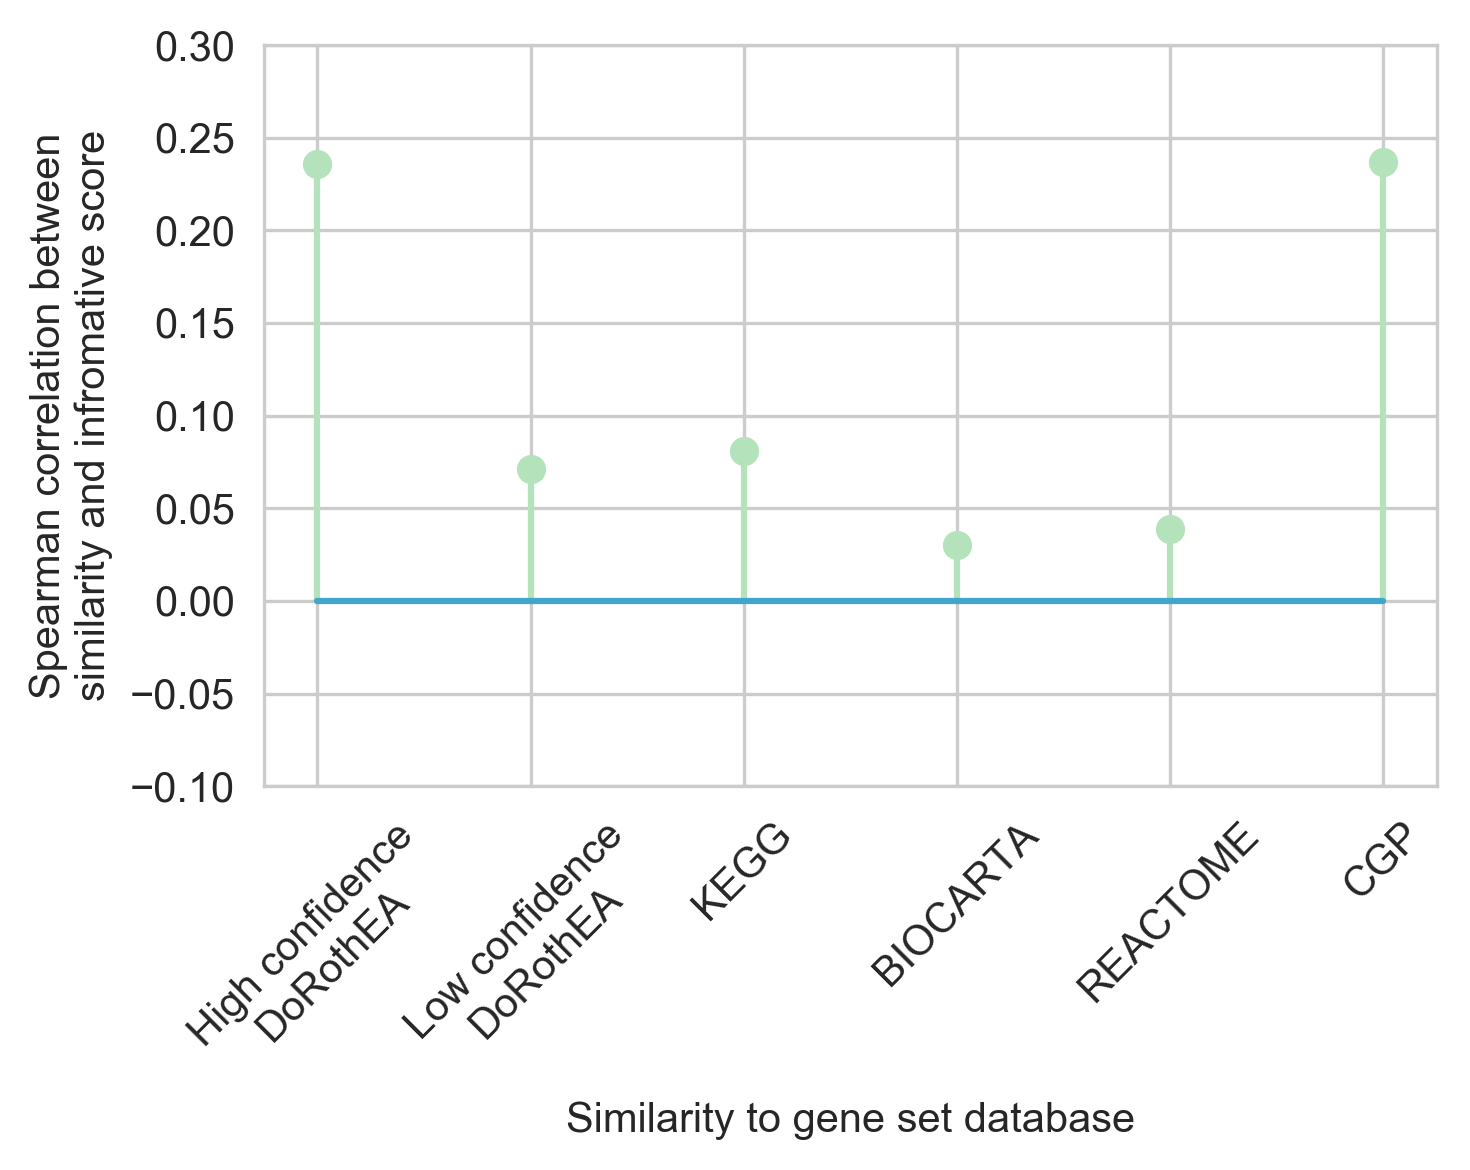

In [36]:
ps, rs = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard')
plt.savefig('../figures/raw/SFig5A.pdf')
print(ps)
print(rs)

BIOCARTA            5.844704e-02
BEST_dorothea_CD    9.476982e-03
CGP                 3.481051e-24
REACTOME            3.381912e-03
KEGG                5.788599e-07
BEST_dorothea_AB    3.598998e-30
dtype: float64
BIOCARTA            0.036924
BEST_dorothea_CD    0.044944
CGP                 0.214361
REACTOME            0.056281
KEGG                0.075275
BEST_dorothea_AB    0.161277
dtype: float64


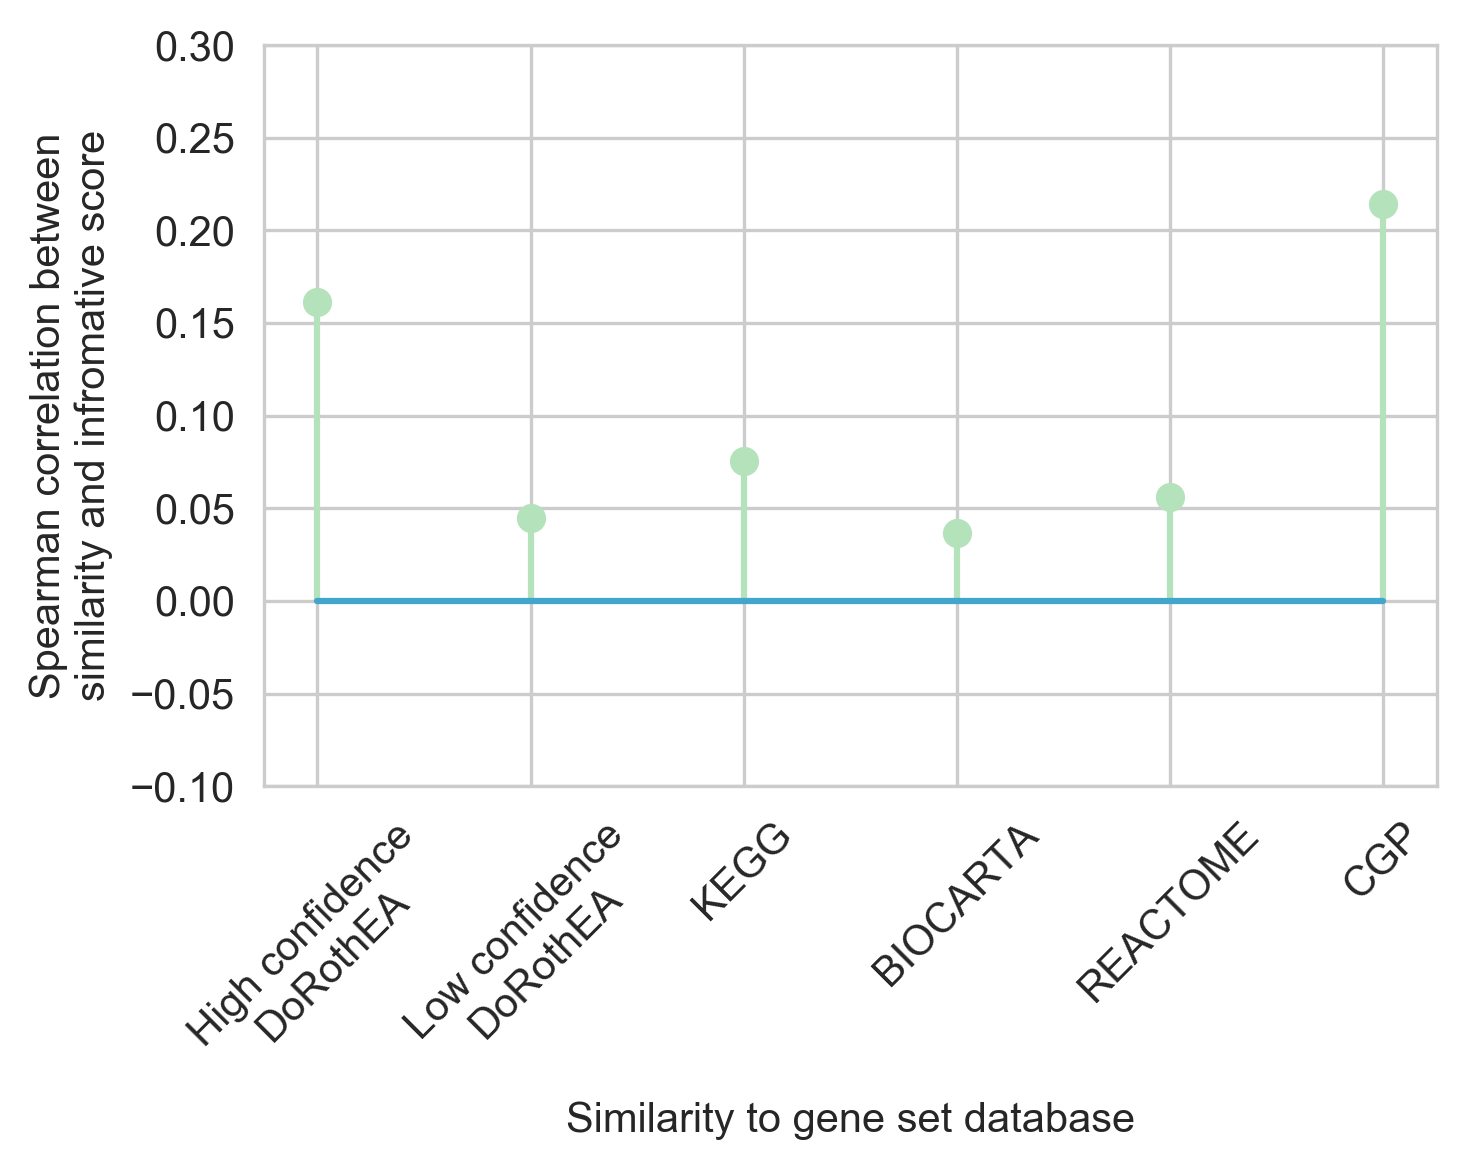

In [37]:
ps, rs = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='progeny',sim_type='jaccard')
plt.savefig('../figures/raw/SFig5B.pdf')
print(ps)
print(rs)

BIOCARTA            2.018022e-43
BEST_dorothea_CD    4.201915e-29
CGP                 3.107928e-37
REACTOME            1.073437e-28
KEGG                1.000000e+00
BEST_dorothea_AB    4.856090e-85
dtype: float64
BIOCARTA            0.197307
BEST_dorothea_CD    0.160548
CGP                 0.266020
REACTOME            0.182570
KEGG                0.001646
BEST_dorothea_AB    0.270377
dtype: float64


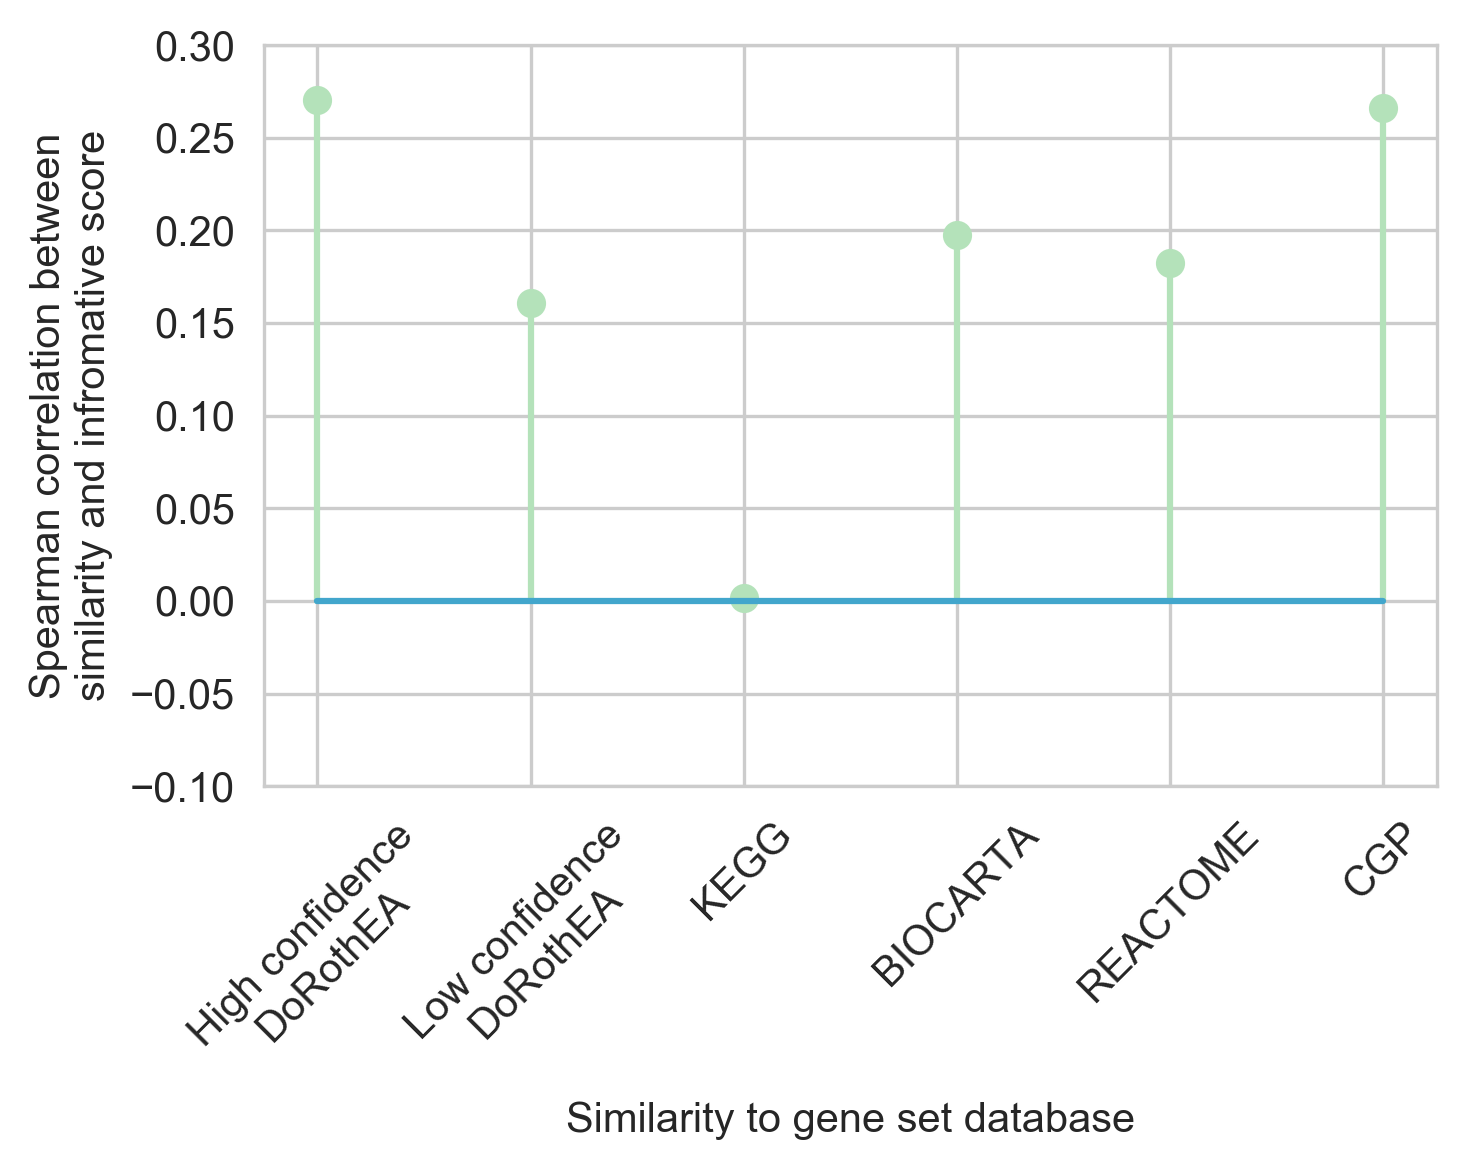

In [40]:
ps, rs = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='overlap')
plt.savefig('../figures/raw/SFig5C.pdf')
print(ps)
print(rs)

BIOCARTA            1.891153e-25
BEST_dorothea_CD    1.020986e-16
CGP                 9.202136e-33
REACTOME            4.900745e-17
KEGG                7.800276e-01
BEST_dorothea_AB    9.874410e-51
dtype: float64
BIOCARTA            0.150529
BEST_dorothea_CD    0.120702
CGP                 0.249657
REACTOME            0.139731
KEGG                0.021398
BEST_dorothea_AB    0.209539
dtype: float64


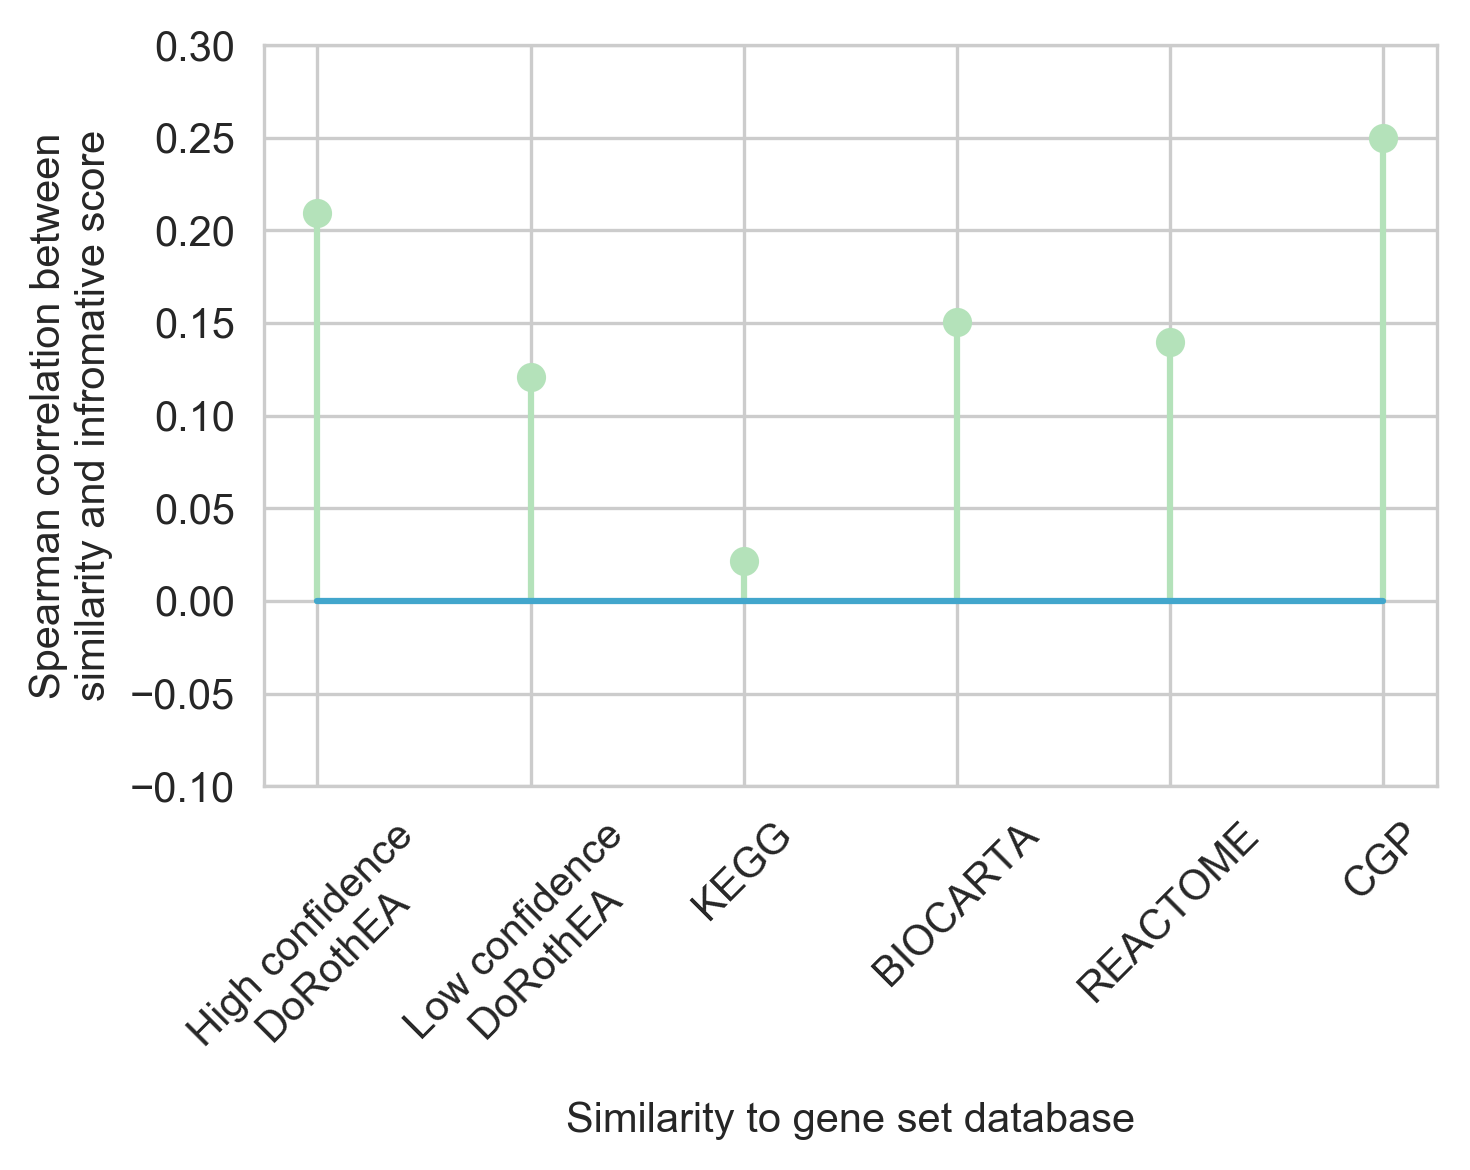

In [41]:
ps, rs = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='progeny',sim_type='overlap')
plt.savefig('../figures/raw/SFig5D.pdf')
print(ps)
print(rs)

BIOCARTA            7.705277e-10
BEST_dorothea_CD    9.630730e-10
CGP                 1.000000e+00
REACTOME            1.761115e-01
KEGG                4.766514e-08
BEST_dorothea_AB    1.927274e-17
dtype: float64
BIOCARTA           -0.091562
BEST_dorothea_CD    0.090712
CGP                -0.027580
REACTOME           -0.035555
KEGG               -0.081318
BEST_dorothea_AB    0.121549
dtype: float64


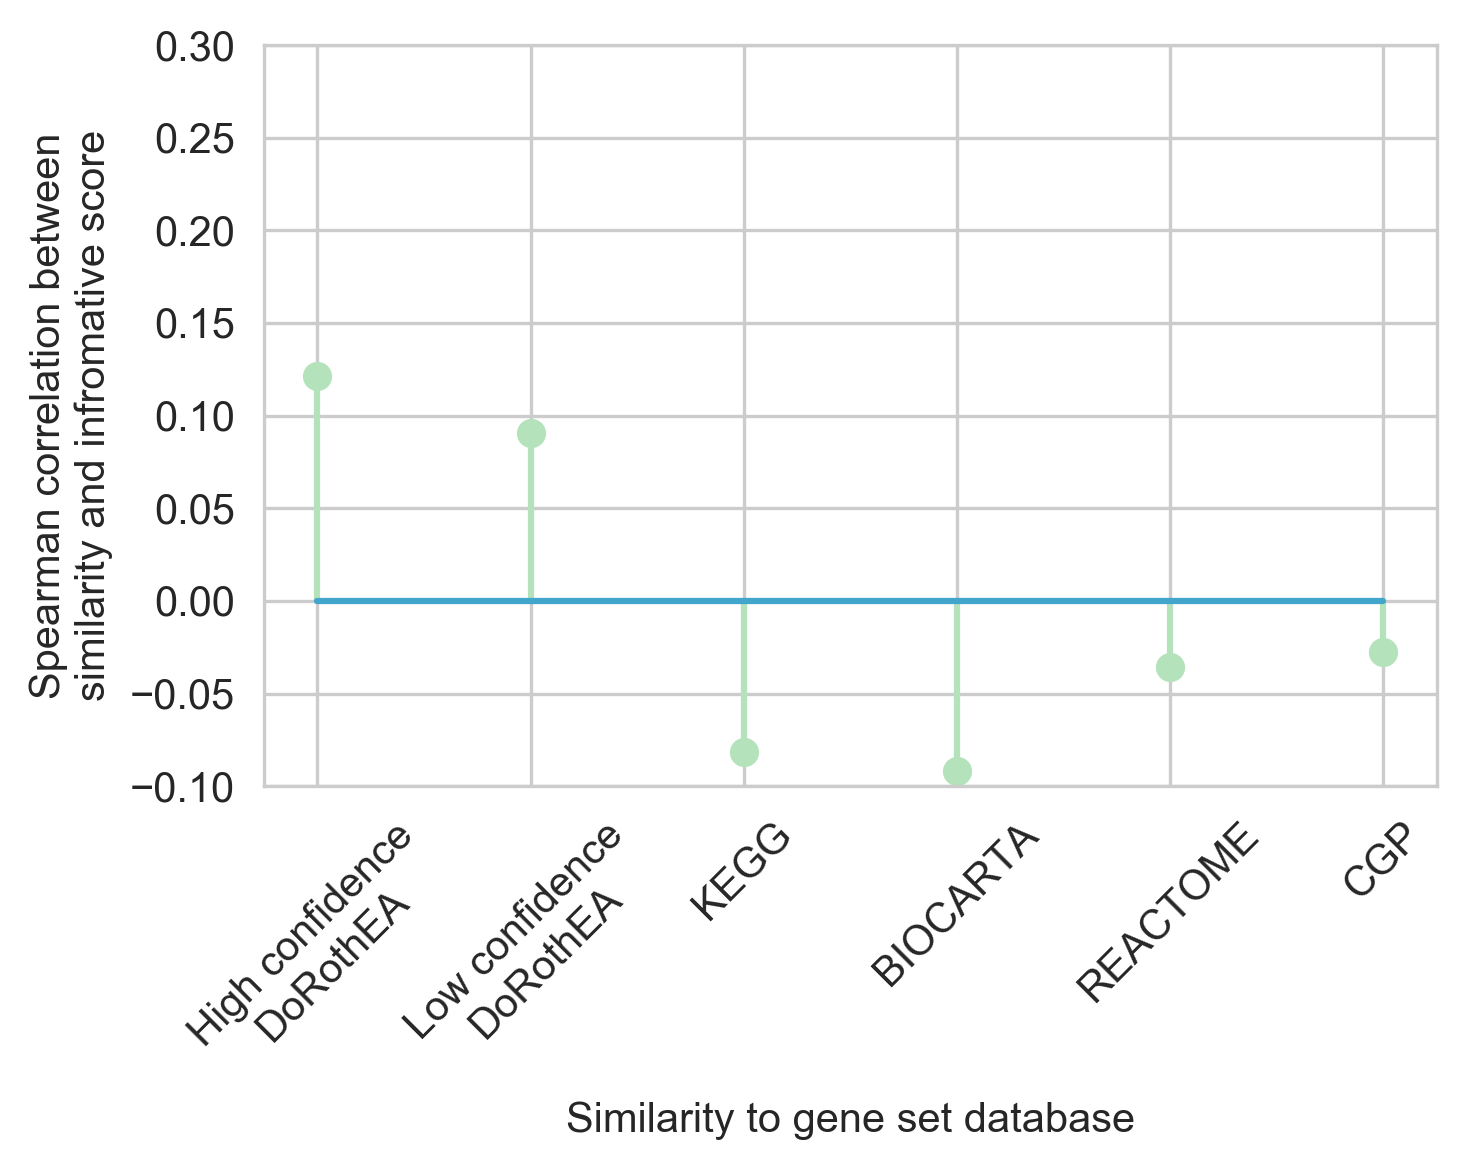

In [42]:
ps, rs = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='gdsc',sim_type='jaccard')
plt.savefig('../figures/raw/SFig5E.pdf')
print(ps)
print(rs)

BIOCARTA            0.003142
BEST_dorothea_CD    1.000000
CGP                 0.000027
REACTOME            0.016417
KEGG                0.400170
BEST_dorothea_AB    0.002369
dtype: float64
BIOCARTA           -0.049470
BEST_dorothea_CD   -0.004343
CGP                -0.096089
REACTOME           -0.048878
KEGG               -0.025883
BEST_dorothea_AB    0.049640
dtype: float64


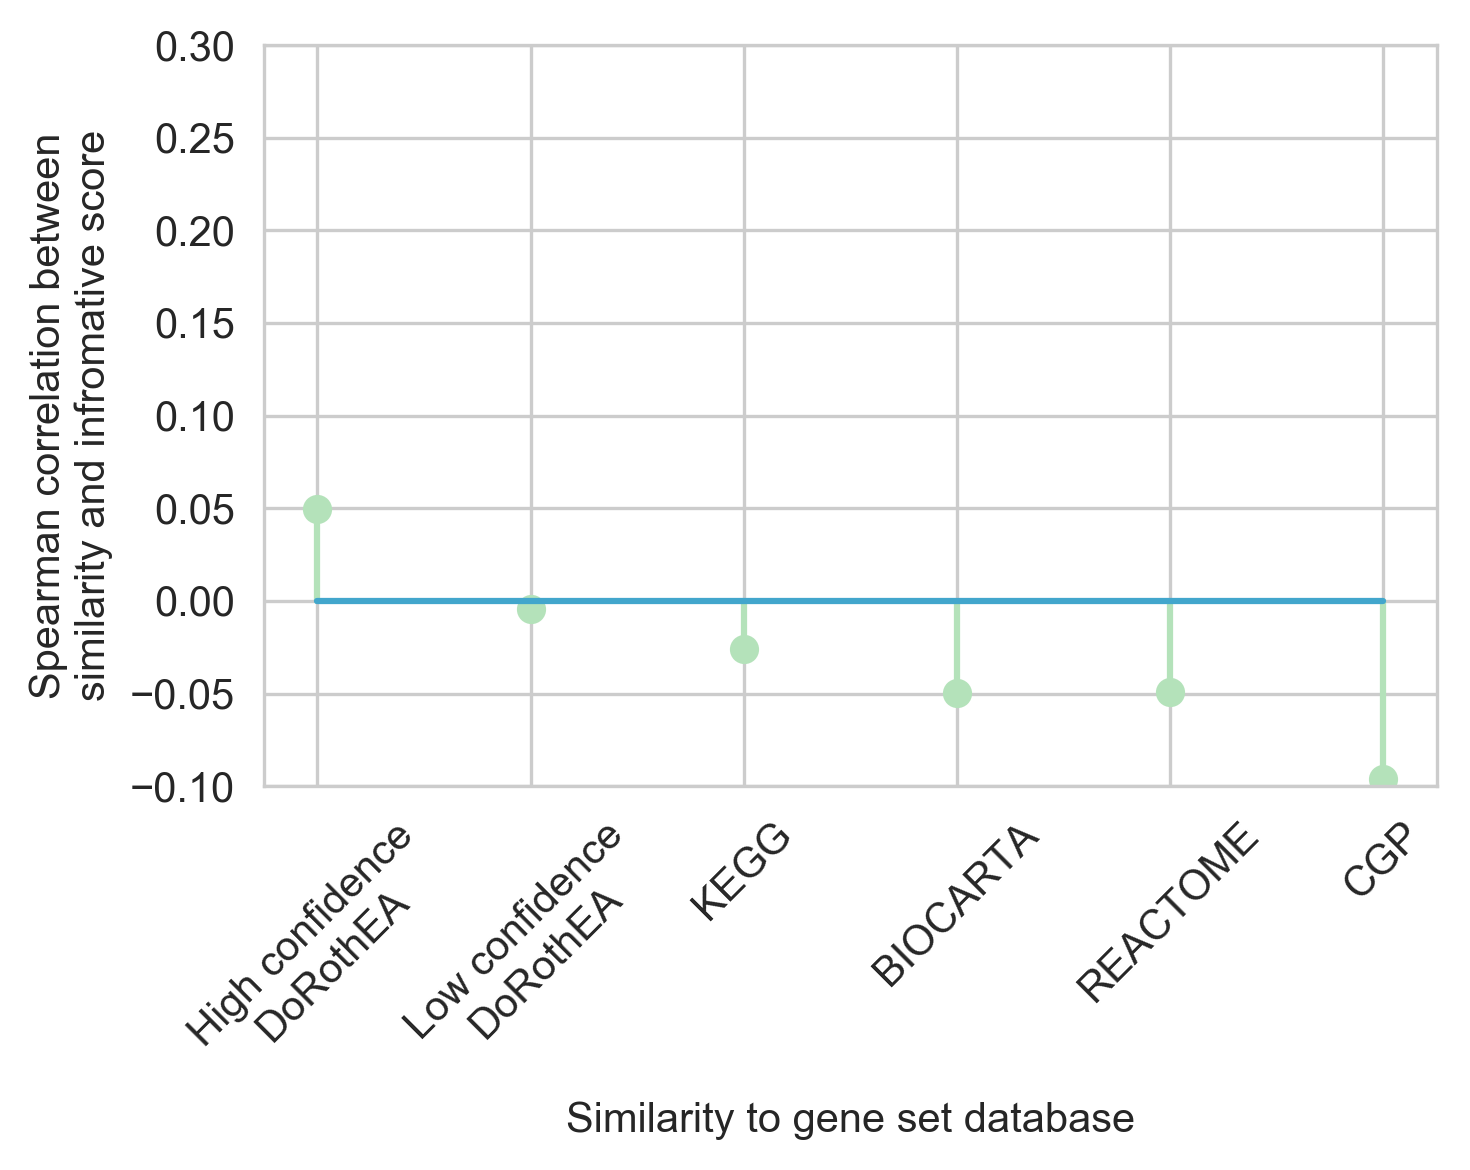

In [43]:
ps, rs = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='gdsc',sim_type='jaccard')
plt.savefig('../figures/raw/SFig5F.pdf')
print(ps)
print(rs)

BIOCARTA            1.000000e+00
BEST_dorothea_CD    3.807639e-20
CGP                 1.000000e+00
REACTOME            2.448166e-02
KEGG                1.323772e-13
BEST_dorothea_AB    1.131250e-16
dtype: float64
BIOCARTA           -0.004625
BEST_dorothea_CD    0.132795
CGP                 0.006736
REACTOME            0.046856
KEGG               -0.107516
BEST_dorothea_AB    0.118734
dtype: float64


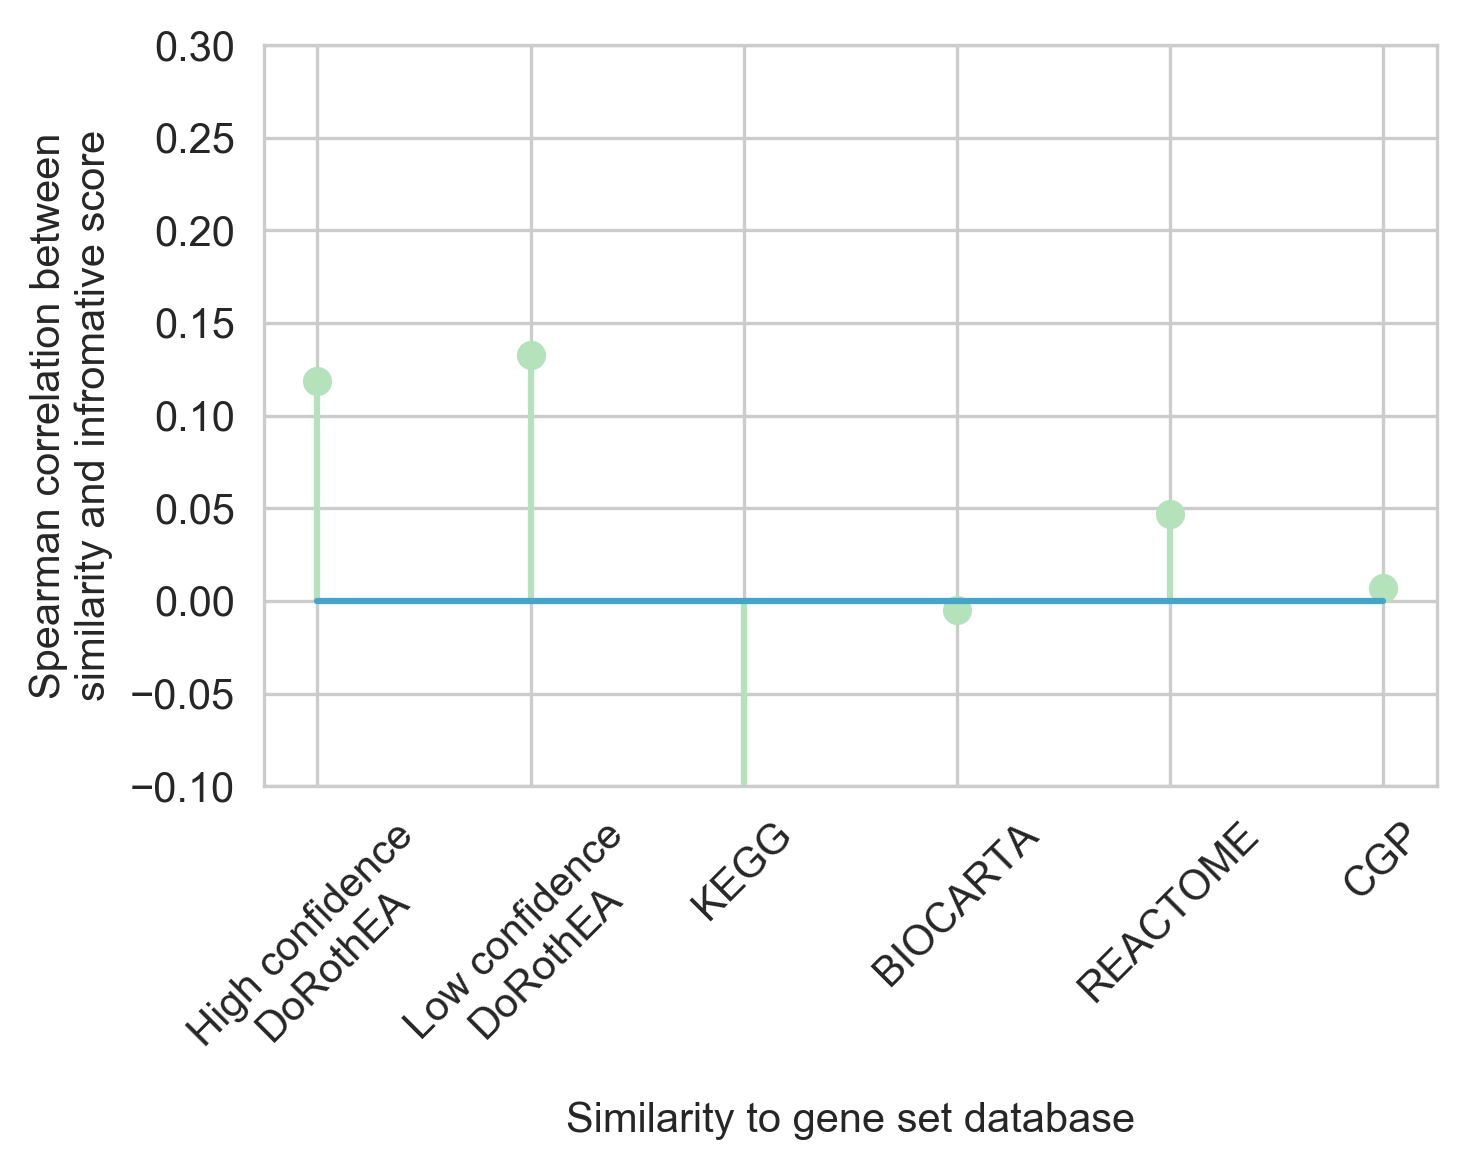

In [44]:
ps, rs = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='gdsc',sim_type='overlap')
plt.savefig('../figures/raw/SFig5G.pdf')
print(ps)
print(rs)

BIOCARTA            4.231477e-02
BEST_dorothea_CD    6.533512e-03
CGP                 8.328213e-01
REACTOME            1.000000e+00
KEGG                1.473053e-04
BEST_dorothea_AB    4.891847e-07
dtype: float64
BIOCARTA            0.038439
BEST_dorothea_CD    0.046405
CGP                -0.031051
REACTOME            0.019709
KEGG               -0.059507
BEST_dorothea_AB    0.075078
dtype: float64


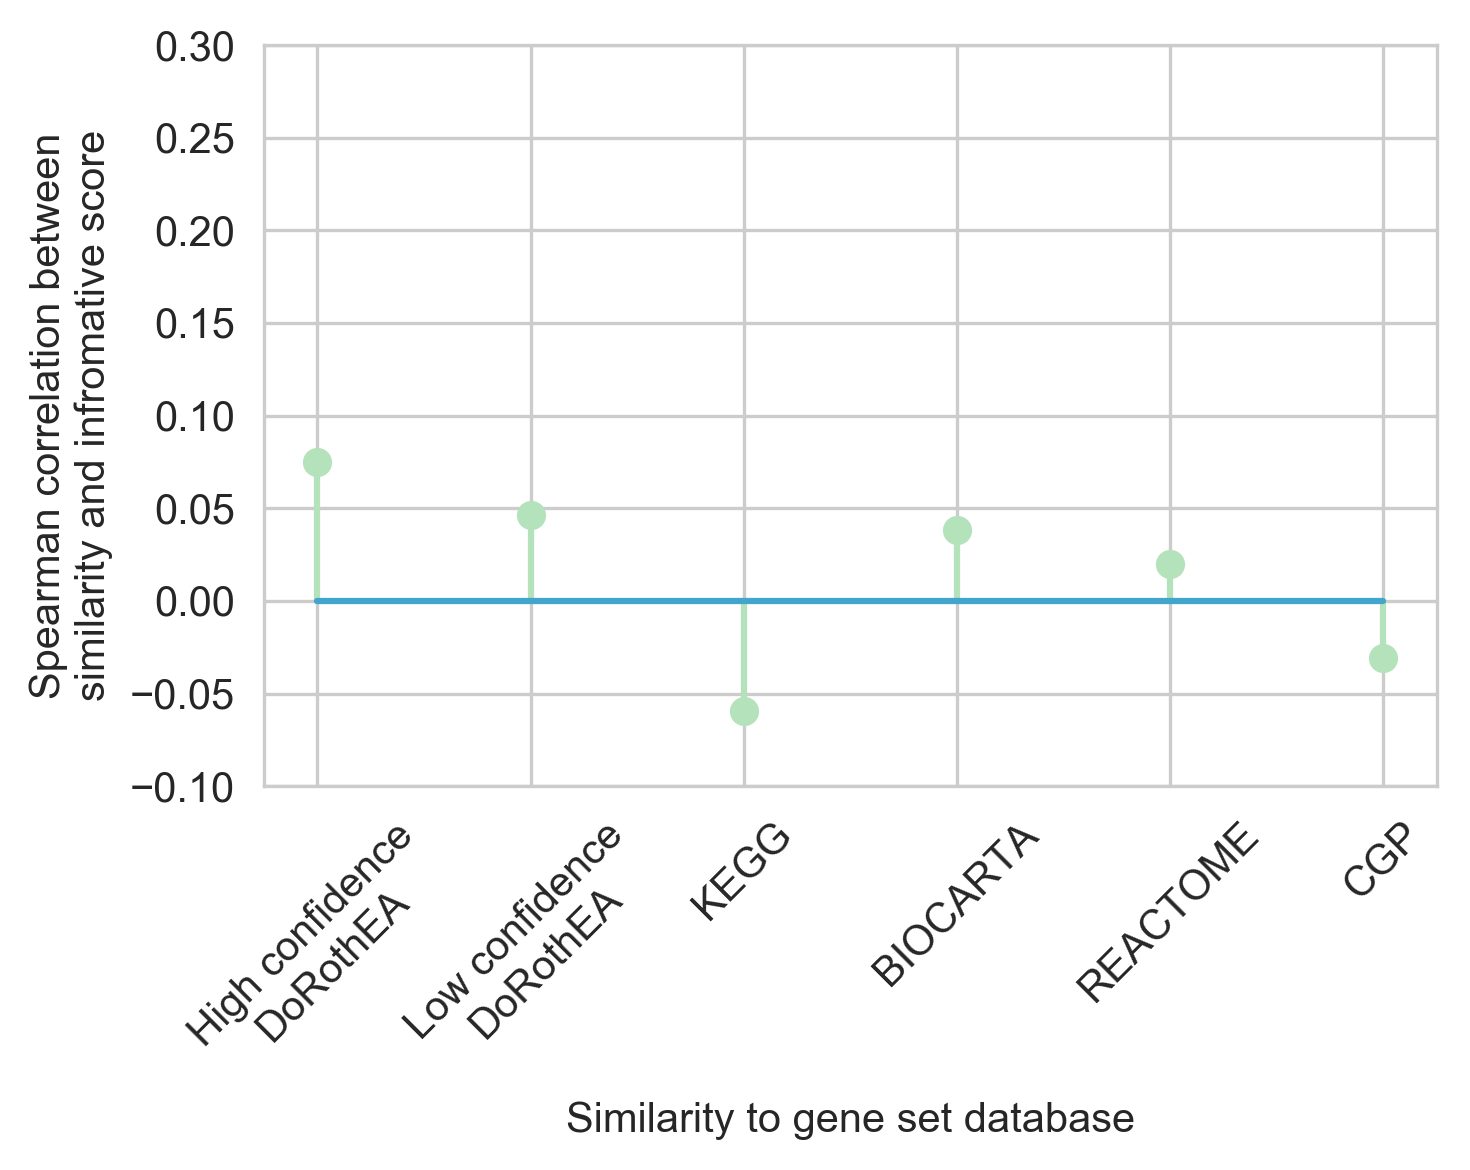

In [45]:
ps, rs = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='gdsc',sim_type='overlap')
plt.savefig('../figures/raw/SFig5H.pdf')
print(ps)
print(rs)